# Cork stopper - 'Hello World!'
***
***

![caption](fig/cork_stopper.png "Cork stopper")

## General formulation of the problem

---
Let us consider a beam $\Omega$ with a rectangular cross-section that is constant along the centerline of the beam, which coincides with the $x$-axis.  
The beam is loaded with the volumetric force density $\mathbf{b}$ acting only in the direction of the $x$-axis. This results in extension or compression of the beam. Additionally, the right end, denoted $\Gamma_{\text{N}}$, is loaded with the constant surface force density $\mathbf{g}$. The beam is fixed at the left end denoted by $\Gamma_{\text{D}}$.

In [1]:
%load_ext tikzmagic

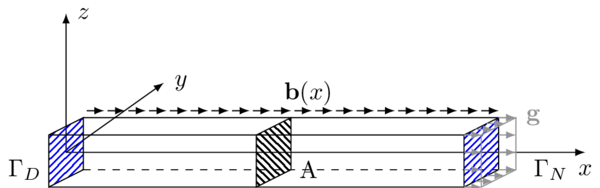

In [2]:
%%tikz -l patterns -s 600,320
\input{fig/formulation.tikz};

### Governing equations
The problem for displacement $\mathbf{u}:\Omega \to \mathbb{R}^3$ of isotropic solid at small strains reads<a id='governing_eqns'></a>
\begin{align*}
	-\text{div} \boldsymbol{\sigma} &= \mathbf{b} && \text{in } \Omega, \\
	\boldsymbol{\sigma} \cdot \mathbf{n} &= \mathbf{g} && \text{on } \Gamma_{\text{N}}, \\
	\mathbf{u} &= \bar{\mathbf{u}} && \text{on } \Gamma_{\text{D}},
\end{align*}
where
\begin{align*}
	\boldsymbol{\sigma} = \lambda (\text{tr} \varepsilon(\mathbf{u})) \mathbf{I} + 2\mu \varepsilon(\mathbf{u})
\end{align*}
is the Cauchy stress tensor (with $\varepsilon(\mathbf{u})$ being the symmetric gradient of $\mathbf{u}$, $\mathbb{I}$ the identity tensor, and $\lambda$ with $\mu$ the Lamé parameters),
$\mathbf{b}$ is the volumetric force density,
$\mathbf{g}$ is the normal traction on the Neumann part of the boundary of $\Omega$,
and $\mathbf{u}_D$ is the prescribed displacement at the Dirichlet part of $\partial \Omega$.
When reducing the problem for an axial dilatation and a radial compression we suppose
\begin{align*}
	\mathbf{u}
	=
	\begin{pmatrix}
		u_x (x) \\
		u_y(y,z) \\
		u_z(y,z)
	\end{pmatrix},
	\quad
	\mathbf{b}
	=
	\begin{pmatrix}
		b_x(x) \\
		0 \\
		0
	\end{pmatrix},
    \quad
	\mathbf{g}
	=
	\begin{pmatrix}
		g_x \\
		0 \\
		0
	\end{pmatrix},
\end{align*}
and that $\mathbf{g}$ is zero on the walls and points in the axial direction at both ends.
The system then partially separates; the equation for the component $u_x$ becomes independent.
Its solutions than enters the equations for $u_y$ and $u_z$ via the traction on the boundary
(here the Poisson's ratio comes into play); however, we are interested in finding solely $u_x$.
When we integrate its equation over the cross-section with the area $A$, we obtain
\begin{align*}
	-A (\lambda + 2\mu)(u_x)'' = A b_x.
\end{align*}
Since we want to describe the material properties rather with Young modulus $E$ and Poisson's ratio $\nu$,
we substitute
\begin{align*}
	\lambda + 2\mu = \frac{E(1-\nu)}{(1+\nu)(1-2\nu)}.
\end{align*}
When supposing $\nu = 0$,
we end up with the reduced problem for $u:=u_x$
\begin{align*}
	-A E u'' &= b \text{ in } (0,L), \\
	u(0) &= 0, \\
	AEu'(L) &= g,
\end{align*}
where $b(x) = Ab_x(x)$ and $g = Ag_x$.
Weak formulation<a id='weak_form'></a> is
\begin{align*}
	u \in V: \int_0^L A E u'(x) \delta u'(x)\, \text{d} x = \int_0^L b(x)\delta u(x)\, \text{d} x + g \delta u(L), \quad \forall \delta u \in V\,,
\end{align*}
where <a id='function_space'></a>$V = \{ v \in H^1(0,L); v(0) = 0\}$[<sup>1</sup>](#fn1 "Definition of Sobolev space").
Note that $H^1(0,L) \subset AC[0,L]$[<sup>2</sup>](#fn2 "Definition of Absolute continuity"), thus $\varphi$ is defined pointwise. Sometimes it is convenient to rewrite the previous variational formulation in the form
\begin{align*}
	u \in V: a(u,\delta u) = L(\delta u), \quad \forall \delta u \in V\,,
\end{align*}
where $a(u,\delta u) = \int_0^L A E u'(x) \delta u'(x)\, \text{d} x$ denotes a bilinear form given by the left-hand side of the formulation and $L(\delta u) = \int_0^L b(x)\delta u(x)\, \text{d} x + g \delta u(L)$ is a linear functional that contains the external loading of the problem.  

<span id='fn1'><sup>1</sup>See the [definition](https://en.wikipedia.org/wiki/Sobolev_space#One-dimensional_case) of the Sobolev space $H^1$.</span>  
<span id="fn2"><sup>2</sup>$AC[0,L]$ denotes the absolutely continuous functions on $[0,L]$, see the [definition](https://en.wikipedia.org/wiki/Absolute_continuity#Definition).</span>  

---
#### Geometric derivation*

Displacement of the bar cross-section located at $x$ is given by $\mathbf{u}(x)$. If we cut an element $[x,x+\Delta x]$ of the bar then the left cross section is displaced by $u(x)=u_x(x)$ in the $x$ direction, and the right one is displaced by $u(x+\Delta x)$, therefore the strain, or the relative deformation, of the element is 
\begin{equation}
    \frac{\Delta u}{\Delta x}=\frac{u(x+\Delta x)-u(x)}{\Delta x}\,.   
\end{equation}
Thus, for an infinitesimal element, the deformation at $x$ is given by
\begin{equation}
    \varepsilon(x)=\lim_{\Delta x \rightarrow 0} \frac{\Delta u}{\Delta x}=\lim_{\Delta x \rightarrow 0}\frac{u(x+\Delta x)-u(x)}{\Delta x} = u'(x)\,.   
\end{equation}
Using 1D stress-strain constitutive relation, i.e. Hooke's law, we get
\begin{equation}
    \sigma(x) = E(x) \varepsilon(x) =E(x) u'(x)\,,
\end{equation}
where $\sigma$ now represents only the $xx$ compononet of the stress tensor $\boldsymbol{\sigma}$.

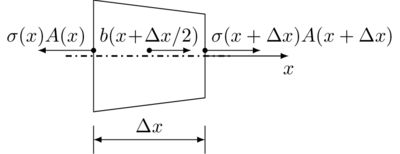

In [3]:
%%tikz -l arrows -s 400,200
\input{fig/equilibrium.tikz};

From static equilibrium of an infinitesimal element, see the previous figure, we get the following force balance
\begin{equation}
    -\sigma(x)A(x) + f(x+\mathrm{d}x/2) + \sigma(x+\mathrm{d}x)A(x+\mathrm{d}x)=0\,,
\end{equation}
which can be recast into
\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}x}\left(\sigma(x)A(x)\right)=-f(x)\,.
\end{equation}
Using the stress relation we get
\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}x}\left(E(x)A(x)u'(x)\right)=-f(x)\,.
\end{equation}
If we suppose that $E(x)=\mathrm{const.}$ and $A(x)=\mathrm{const.}$, we get
\begin{equation}
    -EAu''(x)=f(x)\,,
\end{equation}
which is the same relation we got in the previous derivation.

## Implementation

---
First of all, we must import ``fenics`` library to ``python`` interface. Moreover, we import ``pyplot`` library that is used for graph rendering. And we will also need some features of the ``numpy`` package.

In [4]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

### Problem parameters
Let us set the material parameters of the problem. Following is the table that contains Young modulus and Poisson's ratio for some common materials.

| Material | Young modulus $E\ [\mathrm{GPa}]$ | Poisson's ratio $\nu\ [-]$ |
| -------- |:-------------:| -----:|
| Rubber   | $0.01 - 0.1$  | $0.4999$ |
| **Cork**     | $0.02 - 0.03$    |   $0$ |
| Concrete | $30$      |    $0.1 - 0.2$ |
| Steel    | $200$      |    $0.27 - 0.30$ |

We decided to model a cork stopper, since cork material parameters justify the assumption $\nu=0$ made in the governing equations. Thus, we choose appropriate dimensions of the cork stopper (radius 1&thinsp;cm, length 5&thinsp;cm) and some suitable magnitude of loading $b$ and $g$.

In [5]:
# --------------------
# Parameters
# --------------------
E = 0.025e9  # Young's modulus [Pa]
A = np.pi*1e-4  # Cross-section area of bar [m^-2]
L = 0.05  # Length of bar [m]
n = 20  # Number of elements
b = 0.03  # Load intensity [Pa*m^-3]
g = 0.0005 # External force [Pa*m^-2]

### Geometry of the problem

Next, we define the geometry of the problem. There is always a possibility to use an external mesh defined in *.xml* file. In our case we use the predefined mesh provided directly by FEniCS. Initialization of the FEniCS object ``IntervalMesh(n, x_1, x_2)`` creates an equidistantly discretized one-dimensional mesh with ``n`` elements between the end points ``x_1`` and ``x_2``.

>You can invoke a basic description of any function/object by ``help`` command. Try that for the object ``IntervalMesh``.


In [6]:
%%capture
# %%capture supresses the output of this notebook cell, which is quite lenghty for the help command
help(fe.IntervalMesh)

In [7]:
# --------------------
# Geometry
# --------------------
mesh = fe.IntervalMesh(n, 0.0, L)

We can visually check the geometry of the mesh using the FEniCS ``plot()`` command. The plot object is then displayed by adding the pyplot command ``show()``.

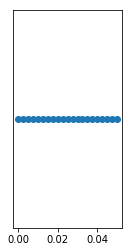

In [8]:
fe.plot(mesh)
plt.show() # this forces the plot to show in a pop-up window when in command line/script environment

### Function spaces definition
Now, we define the function space that contains the solution and test functions by initializing the object ``FunctionSpace(mesh,type,deg)`` with three arguments.  
The first argument is the discretized domain contained in the ``mesh`` variable. Second and third are the type ``type`` of the base functions and the order ``deg`` of these functions respectively.
We will present various types of function elements later in the course. In agreement with the [definition](#function_space) of the function spaces given in the first section, we define the conforming space of finite elements, that is the *Lagrange/Continous Galerkin* element (hence the acronym ``CG``) of order one, in other word, piecewise linear functions.  
  
Then we initialize the test and trial functions specified by the function space as ``TrialFunction`` and ``TestFunction`` objects, respectively.

In [9]:
# --------------------
# Function spaces
# --------------------
V = fe.FunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

### Boundary conditions
As a next step, we specify the geometric boundary of the domain through which we apply the Dirichlet boundary condition. It is necessary to mark those entities of the mesh that constitute the boundaries $\Gamma_{\text{D}}$ and $\Gamma_{\text{N}}$.

In [10]:
# ------------------------
# Boundary markings
# ------------------------
def left(x, on_boundary):
    return fe.near(x[0], 0.0) and on_boundary
# analogously, we could define the marking of the right boundary
def right(x, on_boundary):
    return fe.near(x[0], L) and on_boundary

In the previous, ``on_boundary`` flag is ``True`` for all points that lie on the boundary of the mesh and ``near(x,x0)`` checks whether ``x`` is close to&nbsp;``x0`` (by default, within the tolerance given by the global constant ``DOLFIN_EPS``), which respectively gives the left and the right end of the beam.
  
>When you compare two real numbers in ``python``, always use certain **tolerance**. Value of the tolerance depends on the size of the numbers you compare. For unit sized numbers, ``DOLFIN_EPS = 3e-16`` is sufficient.  

Try it for yourselves. Print the outcomes e.g., of ``0.1+0.1+0.1-0.3`` and ``100.1+100.1+100.1-300.3``:

In [11]:
print(0.1+0.1+0.1-0.3)
print(100.1+100.1+100.1-300.3)

5.551115123125783e-17
-5.684341886080802e-14


There is an equivalent way of marking the boundary. It employs the ``MeshFunction`` object that represents a numerically/Boolean valued function defined on the mesh. More precisely, the first argument in initialization can either be ``‘int’``, ``‘size_t’``, or ``‘double’``, which denotes the integers, unsigned integers and floats, respectively. The Boolean valued function is initialized with the ``‘bool’`` argument.

In [12]:
boundary = fe.MeshFunction("size_t", mesh, mesh.topology().dim()-1,0)
for v in fe.facets(mesh):
    if fe.near(v.midpoint()[0], 0.0):
        boundary[v] = 1 # left boundary
    elif fe.near(v.midpoint()[0], L):
        boundary[v] = 2 # right boundary

The previous ``for`` loop iterates through facets of the mesh (vertices in our example) and assigns the value one to the left boundary and the value two to the right boundary of the bar.

>note: it is preferable to set some default numerical value (e.g., zero) to all the other mesh facets, this can be done either by giving the last optional argument ``0`` in the initialization of the ``MeshFunction`` object or by calling ``boundary.set_all(0)`` **before** the ``for`` loop  

#### Dirichlet boundary conditions
Dirichlet boundary conditions are sometimes called essential, since they determine the definition of the function spaces. In FEniCS, Dirichlet boundary conditions are implemented through the object ``DirichletBC`` initialized with three arguments: the function space, the prescribed value at the boundary, and the corresponding subdomain specified by the previously defined ``left`` function (or equivalently by the ``boundary`` variable and its numerical value at the desired facets).

In [13]:
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, 0.0, left)
# Equivalently, using boundary variable:
#bc = fe.DirichletBC(V, 0.0, boundary, 1)

#### Neumann boundary conditions
 In the [formulation](#governing_eqns) of the problem, we also prescribed a normal force $\mathbf{g}$ at the right boundary of the domain $\Gamma_{\text{N}}$. Such boundary interactions falls into the category of Neumann boundary condition, which is sometimes denoted as natural. The natural boundary conditions are reflected directly in the weak formulation of the problem.
 
 In the [weak formulation](#weak_form) above, the Neumann boundary condition appears as a term from the integration by parts formula. To include this term in our implementation of the problem, we first need to define the integrating measures that correspond to the manifolds representing the geometry of the mesh. To this end, we initialize the ``Measure`` object with input arguments that specify the integral type and the respective geometry to which the measure corresponds.

In [14]:
dx = fe.Measure("dx", mesh)
ds = fe.Measure("ds", subdomain_data = boundary)

### Weak formulation

We are now ready to give the weak form of the problem. One of the very nice features of FEniCS is that the implementation closely imitates the [weak formulation](#weak_form) given above.

In [15]:
# --------------------
# Weak form
# --------------------
#a = E*A*fe.inner(fe.grad(u_tr),fe.grad(u_test))*dx
# One can equivalently write the bilinear form in this one-dimensional problem as
a = E*A*u_tr.dx(0)*u_test.dx(0)*fe.dx
l = b*u_test*dx + g*u_test*ds(2)

We need to supply the subdomain measure ``ds`` with the value of the ``MeshFunction`` object that corresponds to the Neumann part of the boundary $\Gamma_{\text{N}}$, i.e., two.

>*note*: it is possible to access individual elements of the gradient ``grad`` of a function ``u`` via ``u.dx(i)``, where ``i`` specifies the derivative with respect to the ``i``-th coordinate and the enumeration starts with **zero**, do not confuse this with the measure object ``dx`` that specifies the integration domain

>``dot(u,v)`` vs ``inner(u,v)``: FEniCS makes distinction between the inner product and dot product of two elements ``u``, ``v``, ``dot(u,v)`` contracts (sums) over the last index of the first element and the first index of the second element, whereas ``inner(u,v)`` sums over all indices of the elements that must be of the same order

* if ``u``, ``v`` are both vectors (rank 1 tensor), then ``dot(u,v)=inner(u,v)``
* matrix-vector multiplication $\sigma \mathbf{n}$ is computed using ``dot(sigma,n)``

Finally, we call the solver to compute the linear algebraic system generated by the finite element method. FEniCS is prompted to do that by calling the ``solve()`` function supplied with three parameters: linear variational equation, function that will store the resulting approximation and the problem specific Dirichlet boundary conditions.

Let us first introduce the function ``u`` that will contain the finite element solution. In the code environment we define the object ``Function`` pertaining to the function space $V$. Then we can call ``solve(a==l, u, bc)``.

In [16]:
# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)
# Equivalent implementation:
# F = a-l
# problem = fe.LinearVariationalProblem(fe.lhs(F),fe.rhs(F),u,bc)
# solver = fe.LinearVariationalSolver(problem)

## Post processing

---
In the final stage of our simulation we visualize the computational results. This task is easily handled by the ``matplotlib`` library that we imported at the beginning.

For many trivial problems, ours included, there is an exact solution. We can use this solution to benchmark our numerical results. The following cell introduces the exact solution and plots it next to the approximative result given by the finite element method.

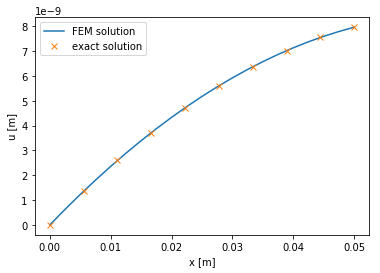

In [17]:
# --------------------
# Exact solution
# --------------------
x_ex = np.linspace(0, L, 10)
u_ex = [-0.5*b*x_ex_i**2/E/A + (g+b*L)*x_ex_i/E/A for x_ex_i in x_ex]

# --------------------
# Post-process
# --------------------
fe.plot(u)
plt.plot(x_ex, u_ex, "x")
plt.xlabel("x [m]")
plt.ylabel("u [m]")
plt.legend(["FEM solution","exact solution"])
plt.show()

## Complete code

---

In [ ]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# Parameters
# --------------------
E = 0.025e9  # Young's modulus
A = np.pi*1e-4  # Cross-section area of bar
L = 0.05  # Length of bar
n = 20  # Number of elements
b = 0.03  # Load intensity
g = 0.0005 # External force

# --------------------
# Geometry
# --------------------
mesh = fe.IntervalMesh(n, 0.0, L)

fe.plot(mesh)
plt.show()

# --------------------
# Function spaces
# --------------------
V = fe.FunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Boundary marking
# --------------------
boundary = fe.MeshFunction("size_t", mesh, mesh.topology().dim()-1,0)
for v in fe.facets(mesh):
    if fe.near(v.midpoint()[0], 0.0):
        boundary[v] = 1 # left boundary
    elif fe.near(v.midpoint()[0], L):
        boundary[v] = 2 # right boundary

dx = fe.Measure("dx", mesh)
ds = fe.Measure("ds", subdomain_data = boundary)
        
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, 0.0, left)

# --------------------
# Weak form
# --------------------
a = E*A*fe.inner(fe.grad(u_tr),fe.grad(u_test))*dx
l = b*u_test*dx + g*u_test*ds(2)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)

# --------------------
# Exact solution
# --------------------
x_ex = np.linspace(0, L, 10)
u_ex = [-0.5*b*x_ex_i**2/E/A + (g+b*L)*x_ex_i/E/A for x_ex_i in x_ex]

# --------------------
# Post-process
# --------------------
fe.plot(u)
plt.plot(x_ex, u_ex, "x")
plt.xlabel("x [m]")
plt.ylabel("u [m]")
plt.legend(["FEM solution","exact solution"])
plt.show()